In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'ERA5', '1dy'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'PERSIANN', '1dy'
product, time_reso = 'SM2RAIN', '1dy'
# product, time_reso = 'CHIRPS', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : SM2RAIN_1dy.json
Number of threads: 20
Neighborhood area: 5x5



In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: SM2RAIN_ASCAT_Italy_1dy_2007_01_01_2022_12_31.nc


<xarray.Dataset> Size: 55MB
Dimensions:  (time: 2192, lat: 51, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31
  * lat      (lat) float32 204B 48.0 47.9 47.8 47.7 47.6 ... 43.3 43.2 43.1 43.0
  * lon      (lon) float32 244B 9.0 9.1 9.2 9.3 9.4 ... 14.6 14.7 14.8 14.9 15.0
Data variables:
    PRE      (time, lat, lon) float32 27MB ...
    NOISE    (time, lat, lon) float32 27MB ...
Attributes:
    description:  SM2RAIN ASCAT daily data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 7kB
Dimensions:  (lat: 26, lon: 31)
Coordinates:
  * lat      (lat) float32 104B 47.0 46.9 46.8 46.7 46.6 ... 44.8 44.7 44.6 44.5
  * lon      (lon) float32 124B 10.5 10.6 10.7 10.8 10.9 ... 13.2 13.3 13.4 13.5
Data variables:
    PRE      (lat, lon) float32 3kB 2.063 1.758 1.461 1.368 ... nan nan nan nan
    NOISE    (lat, lon) float32 3kB 1.0 0.5104 0.01141 0.0116 ... nan nan nan

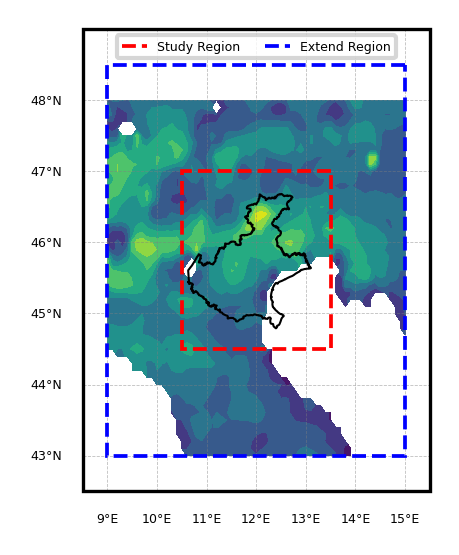

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [ ]:
def wetfrac(array, thresh):
    if np.all(np.isnan(array)):
        return np.nan
    else:
        return np.size(array[array > thresh])/np.size(array)

def space_time_scales_agregations(box_3h, L1, CONDITION, tscales, xscales, npix, thresh):
    nlon = len(box_3h['lon'].data)
    nlat = len(box_3h['lat'].data)
    smax = box_3h.shape[0] # max spatial scale

    Swet_final = []
    Swet_scale = []

    for st in tscales:
        input_data = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)

        for ix, sx in enumerate(xscales):
            if sx == 1:
                rain_tmp = np.zeros([nlon, nlat, input_data.shape[2]])
                wet_tmp = np.zeros([nlon, nlat])
                for i in range(nlon):
                    for j in range(nlat):
                        wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, thresh)
                        rain_tmp[i,j] = input_data[i,j,:].data
                Swet_final.append(np.nanmean(wet_tmp))
                Swet_scale.append(L1)

            elif sx == smax:
                rainfall_tmp = np.nanmean(input_data,axis=(0,1))
                wet_tmp = wetfrac(rainfall_tmp, thresh)
                Swet_final.append(wet_tmp)
                Swet_scale.append(L1*smax)
            
            elif sx > 1 and sx < smax:
                Swet_fraction = []
                for i in range(nlon):
                    for j in range(nlat):
                        box_tmp = input_data[i:i+sx,j:j+sx,:]
                        if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
                            wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
                            Swet_fraction.append(wet_tmp)

                Swet_final.append(np.nanmean(Swet_fraction)) # wet fraction
                Swet_scale.append(L1*sx) # Spatial scales

    WET_MATRIX = np.reshape(Swet_final,(len(tscales),npix))

    return WET_MATRIX

def space_time_scales_agregations_v2(box, L1, tscales, xscales, npix, thresh):
    nlon = len(box['lon'].data)
    nlat = len(box['lat'].data)
    smax = box.shape[0]
    Swet_final = []
    Swet_scale = []

    for st in tscales:
        # input_data = box.resample(time='{}h'.format(st)).sum(dim='time', skipna = True)
        input_data = box.coarsen(time=st, boundary="trim").sum()

        for ix, sx in enumerate(xscales):
            if sx == 1:
                rain_tmp = np.zeros([nlon, nlat, input_data.shape[2]])
                wet_tmp = np.zeros([nlon, nlat])
                for i in range(nlon):
                    for j in range(nlat):
                        wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, thresh)
                        rain_tmp[i,j] = input_data[i,j,:].data
                Swet_final.append(np.nanmean(wet_tmp))
                Swet_scale.append(L1)

            elif sx == smax:
                rainfall_tmp = input_data.mean(axis=(0,1))
                wet_tmp = wetfrac(rainfall_tmp, thresh)
                Swet_final.append(np.nanmean(wet_tmp))
                Swet_scale.append(L1*smax)
            
            elif sx > 1 and sx < smax:
                Swet_fraction = []
                for i in range(nlon):
                    for j in range(nlat):
                        box_tmp = input_data[i:i+sx,j:j+sx,:]
                        if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
                            wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
                            Swet_fraction.append(wet_tmp)

                Swet_final.append(np.nanmean(Swet_fraction))
                Swet_scale.append(L1*sx)

    WET_MATRIX = np.reshape(Swet_final,(len(tscales),npix))
    
    return WET_MATRIX

In [10]:
np.where((lats<45.75)&(lats>45.45)),np.where((lons<12.75)&(lons>12.3))

((array([23, 24, 25]),), (array([34, 35, 36, 37]),))

In [11]:
## CHIRPS
# lat_idx, lon_idx = 49, 72 # with NaN
# lat_idx, lon_idx = 49, 65 # with values

## SM2RAIN
lat_idx, lon_idx = 25, 34 # with NaN
# lat_idx, lon_idx = 22, 34 # with values

DATA_in = PRE_data
lat_c, lon_c = lats[lat_idx], lons[lon_idx]

PARAM = param
L1 = param['L1']
npix = param['npix']
thresh = param['thresh']

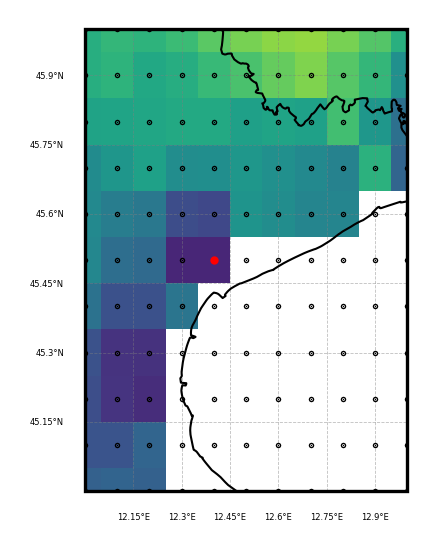

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([12, 13, 45, 46],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 2, 'color': 'k'}
gl.ylabel_style = {'size': 2, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))
ax1.scatter(lon2d, lat2d, s=0.1, color='k', zorder=10)
ax1.scatter(lon_c, lat_c, s=1, color='r', zorder=10)

In [24]:
BOX['time']

<xarray.DataArray 'time' (time: 2192)> Size: 18kB
array(['2007-01-01T00:00:00.000000000', '2007-01-02T00:00:00.000000000',
       '2007-01-03T00:00:00.000000000', ..., '2012-12-29T00:00:00.000000000',
       '2012-12-30T00:00:00.000000000', '2012-12-31T00:00:00.000000000'],
      shape=(2192,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31

In [13]:
# def beta_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
print(f'Time Resolution: {time_reso}')
BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])*3
print()

print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")

BOX = BOX.transpose("lon", "lat", "time")
BOX = BOX['PRE']

if np.all(np.isnan(BOX[2,2,:].values)):
    BETA = np.nan
    pass
    # return BETA
else:
    smax = BOX.shape[0]
    # tscales = tscales[tscales < param['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*param['L1']

    print(len(tscales))
    WET_MATRIX = space_time_scales_agregations_v2(BOX, L1, tscales, xscales, 2*param['npix']+1, thresh)
    WET_MATRIX_OLD = space_time_scales_agregations(
                BOX, 
                param['L1'], 
                param['condition'], 
                tscales, 
                xscales, 
                2*param['npix']+1, 
                param['thresh'])

    nxscales = np.size(xscales)
    
    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
    WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX_OLD[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                param['L1'], 
                param['npix'])

    origin_ref = [param['origin_x'], param['origin_t']]
    target_ref = [param['target_x'], param['target_t']]

    beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)
    print(beta)

# return WET_MATRIX

Time Resolution: 1dy

Neighborhood area: 5x5
13


/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271/3503693788.py:84: RuntimeWarning: Mean of empty slice
  wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
/tmp/ipykernel_45271

1.2137230899350662


In [14]:
verify = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        tmp = BOX[i,j,:].values
        if np.all(tmp):
            verify[i,j] = 0
        else:
            verify[i,j] = 1

Text(0.0, 1.0, '(c) New Wet Fraction')

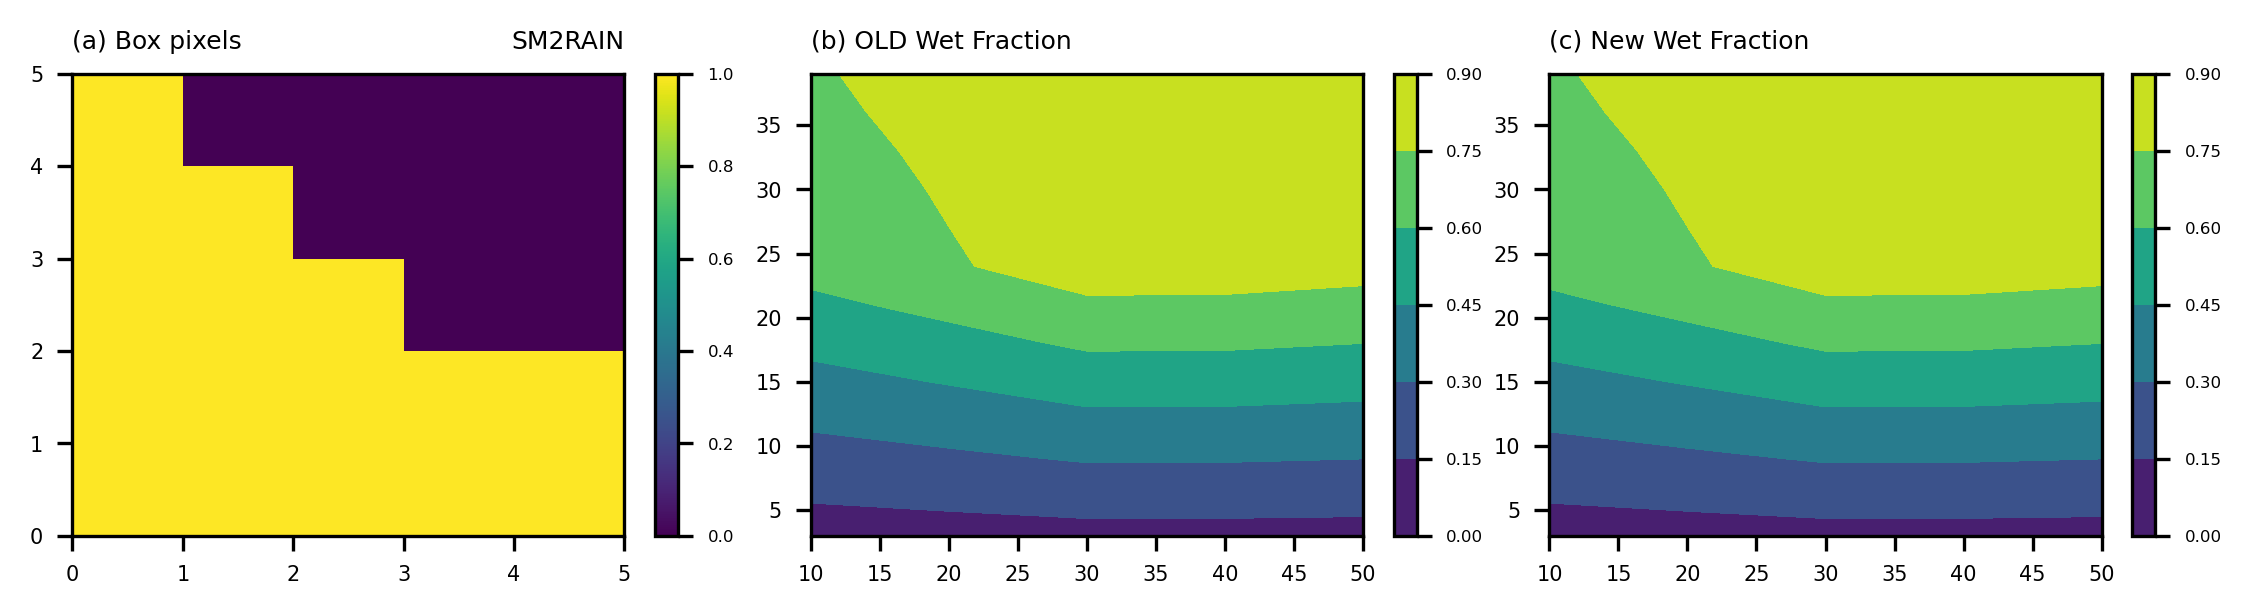

In [15]:
x_s,y_t = np.meshgrid(xscales_km, tscales)

fig = plt.figure(figsize=(9,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
a1 = plt.pcolormesh(verify.T)
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) Box pixels',loc='left',fontsize=6)
ax1.set_title(product,loc='right',fontsize=6)

ax1 = plt.subplot(gs[0, 1])
a1 = plt.contourf(x_s,y_t,WET_MATRIX_OLD)
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) OLD Wet Fraction',loc='left',fontsize=6)

ax1 = plt.subplot(gs[0, 2])
a1 = plt.contourf(x_s,y_t,WET_MATRIX)
cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) New Wet Fraction',loc='left',fontsize=6)

In [16]:
beta

np.float64(1.2137230899350662)

In [17]:
tscales*3

array([  9,  18,  27,  36,  45,  54,  63,  72,  81,  90,  99, 108, 117])

In [27]:
input_data = BOX.resample(time='{}h'.format(18)).sum(dim='time', skipna = False)
input_data['time']

<xarray.DataArray 'time' (time: 2922)> Size: 23kB
array(['2007-01-01T00:00:00.000000000', '2007-01-01T18:00:00.000000000',
       '2007-01-02T12:00:00.000000000', ..., '2012-12-29T06:00:00.000000000',
       '2012-12-30T00:00:00.000000000', '2012-12-30T18:00:00.000000000'],
      shape=(2922,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 23kB 2007-01-01 ... 2012-12-30T18:00:00

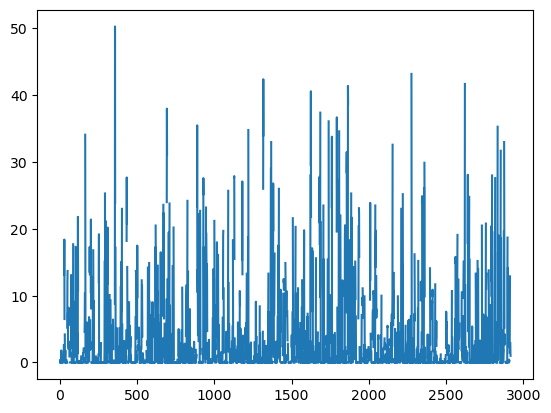

In [28]:
plt.plot(input_data[0,0,:])

## Interpolar datos

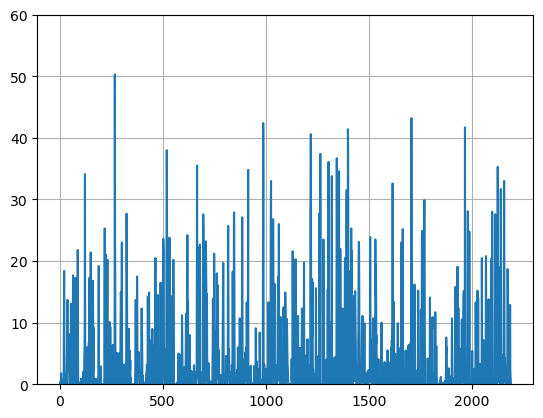

In [57]:
input_data2 = BOX.resample(time='1d').interpolate('linear')

plt.plot(input_data2[0,0,:])
plt.ylim(0,60)
plt.grid()

In [ ]:
input_data = BOX.resample(time='{}h'.format(24)).sum(dim='time', skipna = False)
input_data['time']

<xarray.DataArray 'time' (time: 2192)> Size: 18kB
array(['2007-01-01T00:00:00.000000000', '2007-01-02T00:00:00.000000000',
       '2007-01-03T00:00:00.000000000', ..., '2012-12-29T00:00:00.000000000',
       '2012-12-30T00:00:00.000000000', '2012-12-31T00:00:00.000000000'],
      shape=(2192,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31

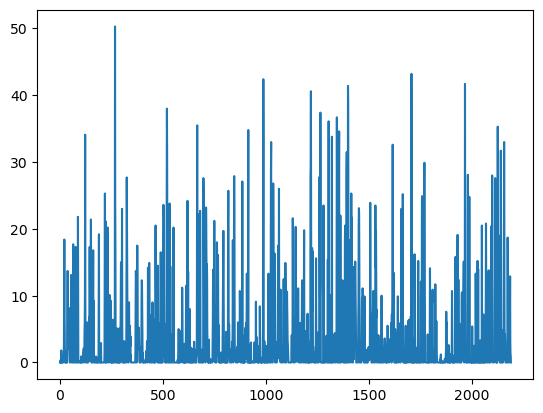

In [21]:
plt.plot(input_data[0,0,:])